# Image Reconstruction using traditional methods

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torchvision.transforms as transforms
from torchvision import datasets
import torch
import torch.nn.utils as utils
import sklearn
import wandb

desktop_path = '/Users/jocelynornelasmunoz/Desktop/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

import MURA as mura
from Reconstruct import reconstruction_cnn
from Classify import classification_cnn
# import confusion_matrix as cm
# import wandb_functions as wf

Using path =  /Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/


In [3]:
# Update plotting parameters
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [15,7],#[15,10],
})

In [4]:
%%time
# define parameters 
params = {
  "dataset": "MNIST_mura",
  "learning_rate": 1e-3,
  "batch_size": 100,
  "p": 23, # size of array (has to be prime)
}

# Compute MURA encoder and decoder
params['A'] = mura.create_binary_aperture_arr(params['p'])
params['G'] = mura.create_decoding_arr(params['A'])

CPU times: user 1.48 ms, sys: 57 µs, total: 1.54 ms
Wall time: 1.53 ms


In [5]:
# Load data
mura_train_data, mura_eval_data, mura_test_data, loaders = classification_cnn.load_encoded_data(params)
#mura_train_data, mura_eval_data, mura_test_data, loaders = reconstruction_cnn.load_data(params)

In [7]:
obs = mura_train_data[0][0][0].numpy()
true = mura_train_data[0][1][0].numpy()
digit = mura_train_data[0][2]
# noise_level = mura_train_data[0][3]

# Correlation Analysis

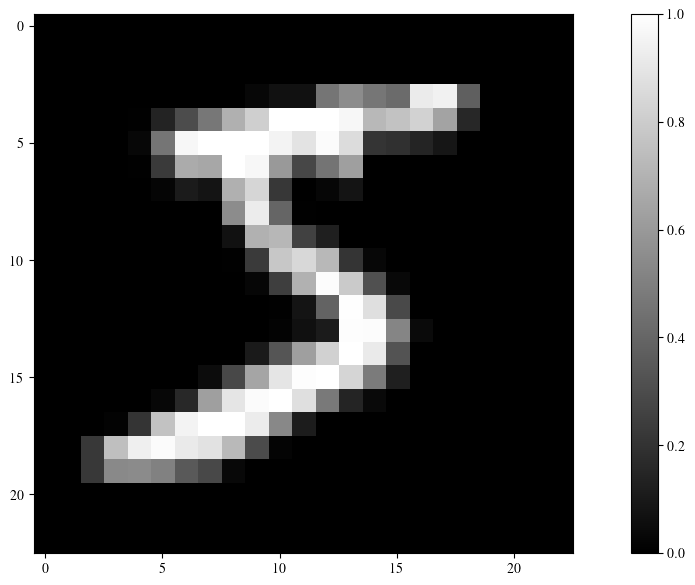

In [8]:
plt.imshow(mura.normalize(mura.FFT_convolve(obs, params['G'], params['p'])), cmap='gray')
plt.colorbar()
plt.show()

# Deconvolution via FFT

In [22]:
from scipy.fft import fft2, ifft2

According to E. Fenimore and T. Cannon, the recorded image using coded aperture imaging is given by 
$$D = (S*A)+B$$
where 
- $D$ is the recorded image (observation)
- $S$ is the original image (signal)
- $A$ is the aperture
- $B$ is background noise
- $*$ is the correlation operator

Then in deconvolution methods,
$$\hat{S} = R \mathcal{F}^{-1} \big[\mathcal{F}(D)/\mathcal{F}(A)\big]$$
where
- $\mathcal{F}$ is the Fourier Transform
- $\mathcal{F}^{-1}$ is the inverse Fourier Transform
- $R$ is the reflection operator

In [23]:
conv_OA = np.squeeze(np.real(ifft2(fft2(obs)/fft2(params['A']))))

In [24]:
deconvolved_obs = np.roll(conv_OA, [int((params['p']-1)/2),int((params['p']-1)/2)], axis=(0,1))

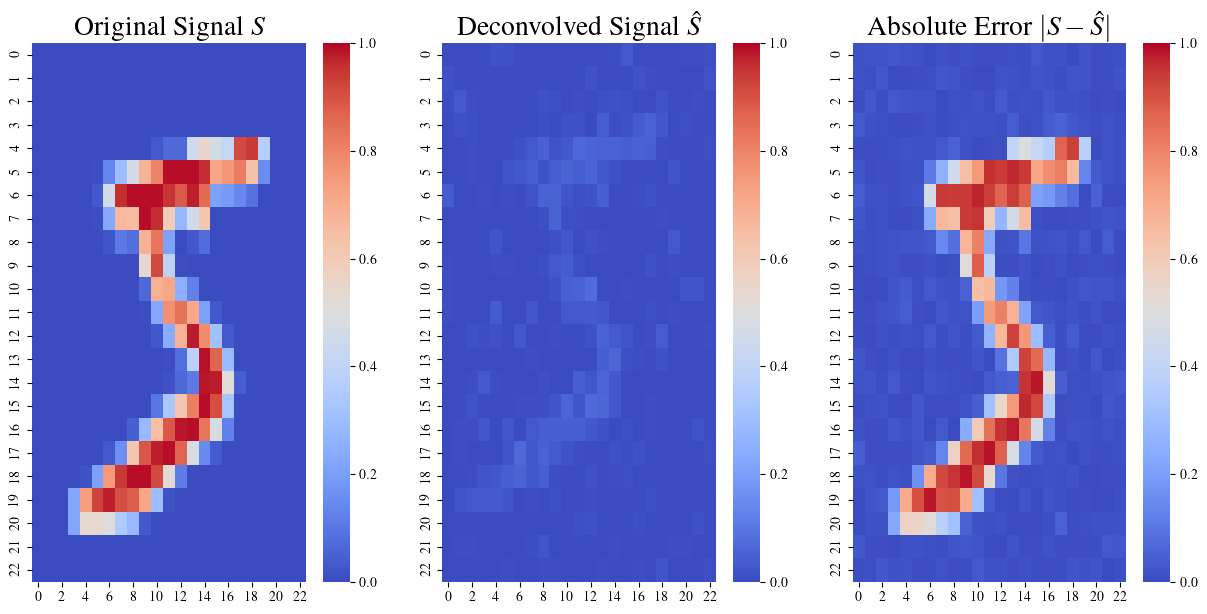

In [25]:
title_size=20
fig, axs = plt.subplots(1,3)
sns.heatmap(np.squeeze(true), cmap='coolwarm', ax = axs[0], vmin=0, vmax = 1)
sns.heatmap(deconvolved_obs, cmap='coolwarm', ax = axs[1], vmin=0, vmax = 1)
sns.heatmap(np.abs(deconvolved_obs - np.squeeze(true)), cmap='coolwarm', ax = axs[2], vmin=0, vmax = 1)

axs[0].set_title("Original Signal $S$", fontsize =title_size)
axs[1].set_title("Deconvolved Signal $\hat{S}$", fontsize =title_size)
axs[2].set_title("Absolute Error $|S - \hat{S}|$", fontsize =title_size)
plt.show()